## Graph Neural Network  

In this question, we implement a graph neural networks based upon PyTorch and PyTorch Geometric to predict the aqueous solubility from molecular structure.

This problem is a regression problem, where given the molecular structures, we build a graph neural network to predict the log solubility.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import Linear
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import random
import sys
import warnings



def get_dataset(save_path):
    # '''
    # read data from .npy file 
    # no need to modify this function
    # '''
    raw_data = np.load(save_path, allow_pickle=True)
    dataset = []
    for i, (node_f, edge_index, edge_attr, y) in enumerate(raw_data):
        sample = Data(
            x=torch.tensor(node_f, dtype=torch.float),
            y=torch.tensor([y], dtype=torch.float),
            edge_index=torch.tensor(edge_index, dtype=torch.long),
            edge_attr=torch.tensor(edge_attr, dtype=torch.float)
        ) 
        dataset.append(sample)
    return dataset

class GraphNet(torch.nn.Module):
    def __init__(self, n_features, output_dim=1):
        super(GraphNet, self).__init__()
        self.conv1 = GCNConv(n_features, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 128)
        self.lin = Linear(128, output_dim)
        self.dropout_rate1 = 0.4  # First dropout
        self.dropout_rate2 = 0.7  # Second dropout 
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate1, training=self.training) 
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate2, training=self.training)  
        x = F.relu(self.conv4(x, edge_index))
        x = self.lin(x)
        x = global_mean_pool(x, data.batch)
        return x
    
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    
    # Optional: Enable deterministic behavior in PyTorch
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False        


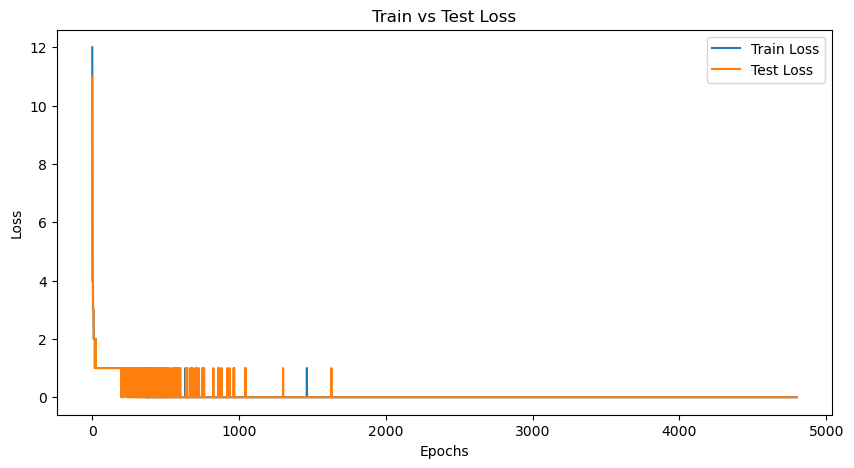

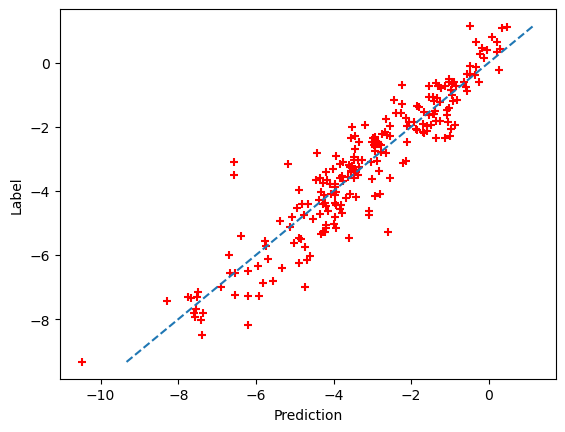

In [2]:
def main():
    # Redirect standard output to a file
    original_stdout = sys.stdout  # Save a reference 
    with open('output.txt', 'w') as f:
        sys.stdout = f  

        set_seed(42)
        
        # load data and build the data loader
        train_set = get_dataset('train_set.npy')
        test_set = get_dataset('test_set.npy')
        train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

        # number of features in the dataset
        n_features = 37

        # build your GNN model
        model = GraphNet(n_features)

        # define your loss and optimizer
        loss_func = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        print(model)

        hist = {"train_loss": [], "test_loss": []}
        num_epoch = 4800
        
        min_test_loss = float('inf')
        min_test_loss_epoch = -1
        
        for epoch in range(1, 1 + num_epoch):
            model.train()
            train_loss_all = 0
            num_train_graphs = 0
            for data in train_loader:
                data = data.to('cpu')  
                optimizer.zero_grad()
                output = model(data)
                loss = loss_func(output, data.y.view(-1, 1))
                loss.backward()
                optimizer.step()
                train_loss_all += loss.item() * data.num_graphs
                num_train_graphs += data.num_graphs
            train_loss = train_loss_all 

            model.eval()
            test_loss_all = 0
            num_test_graphs = 0
            prediction = np.zeros(len(test_set))
            label = np.zeros(len(test_set))
            idx = 0
            
            
            with torch.no_grad():
                for data in test_loader:
                    data = data.to('cpu')  # or 'cuda' if using GPU
                    output = model(data)
                    prediction[idx:idx+len(output)] = output.squeeze().detach().numpy()
                    label[idx:idx+len(output)] = data.y.detach().numpy()
                    idx += len(output)

                    loss = loss_func(output, data.y.view(-1, 1))
                    test_loss_all += loss.item() * data.num_graphs
                    num_test_graphs += data.num_graphs
                prediction = np.array(prediction).squeeze()
                label = np.array(label).squeeze()
                test_loss = np.sum((prediction - label)**2)
 

            hist["train_loss"].append(train_loss//len(train_set))
            hist["test_loss"].append(test_loss//len(test_set))
            
            if test_loss < min_test_loss:
                min_test_loss = test_loss
                min_test_loss_epoch = epoch
                
            if epoch % 400 == 0 or epoch == num_epoch:
                print(f'Epoch: {epoch}, Train loss: {train_loss/len(train_set):.3f}, Test loss: {test_loss/len(test_set):.3f}')
                #print(f"min_test_loss: {min_test_loss:.2f}, min_test_loss_epoch: {min_test_loss_epoch}")

        
        total_mse = np.sum((prediction - label)**2)
        print(f'Final summed square error on test set: {total_mse:.3}')
        
        torch.save(model.state_dict(), 'gnn_weights.pt')
        
        
        plt.figure(figsize=(10, 5))
        plt.plot(hist["train_loss"], label='Train Loss')
        plt.plot(hist["test_loss"], label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Train vs Test Loss')
        plt.legend()
        plt.show()
        
        x = np.linspace(np.min(label), np.max(label))
        y = np.linspace(np.min(label), np.max(label))
        ax = plt.subplot(1,1,1)
        ax.scatter(prediction, label, marker='+', c='red')
        ax.plot(x, y, '--')
        plt.xlabel("Prediction")
        plt.ylabel("Label")
        plt.show()


        # Reset stdout
        sys.stdout = original_stdout



warnings.filterwarnings('ignore', category=UserWarning, message="Creating a tensor from a list of numpy.*")
warnings.filterwarnings('ignore', category=UserWarning, message="'data.DataLoader' is deprecated, use 'loader.DataLoader' instead")

if __name__ == "__main__":
    main()
    